### Predição do conjunto de dados m_694.csv com o modelo ARIMA

### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import os

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_694.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('5min').interpolate()
workload = workload[-12*24*3:] # 5min * 12 * 24 * 3 = 3 days
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-06 00:00:00,m_694,25.0,96.0,NaN,NaN,46.14,39.77,5.0
1970-01-06 00:05:00,m_694,31.0,97.0,NaN,NaN,46.15,39.78,5.0
1970-01-06 00:10:00,m_694,34.0,94.0,NaN,NaN,46.15,39.78,8.0
1970-01-06 00:15:00,m_694,31.0,92.0,NaN,NaN,46.16,39.79,4.0
1970-01-06 00:20:00,m_694,32.0,94.0,NaN,NaN,46.16,39.79,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:35:00,m_694,86.0,91.0,0.35,0.0,51.46,44.74,4.0
1970-01-08 23:40:00,m_694,86.0,92.0,0.27,0.0,51.46,44.75,6.0
1970-01-08 23:45:00,m_694,85.0,92.0,0.45,0.0,51.46,44.75,6.0


<AxesSubplot:xlabel='time_stamp'>

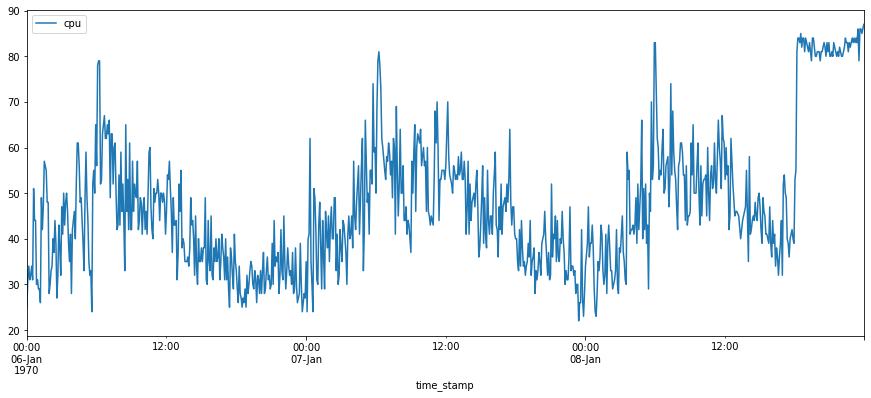

In [3]:
workload[['cpu']].plot(figsize=(15,6))

###  Separar treino e teste

In [4]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/3
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [5]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     55.806867
ar.L1      0.915112
sigma2    53.109876
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [6]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p = [0,1,2,3,4,5]
max_d = [1]
max_q = [0,1,2,3,4,5]

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in max_p:
    for d in max_d:
        for q in max_q:
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    # faz previsões
    X = [x for x in train_set]
    predictions = list()
    for i in range(len(test_set)):
        model = ARIMA(X, order=order, enforce_stationarity=False)
        model_fit = model.fit()
        predict = model_fit.forecast()[0]
        predictions.append(predict)
        X.append(test_set[i])
        
    # guarda os erros de cada previsão em uma lista
    error = np.sqrt(mean_squared_error(test_set, predictions))
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 1, 0) 7.434669162481647 | (0, 1, 1) 6.957561228282519 | (0, 1, 2) 6.982616887770805 | (0, 1, 3) 6.94724888287681 | (0, 1, 4) 6.964401617213212 | (0, 1, 5) 6.957356634808115 | (1, 1, 0) 6.918851894988443 | (1, 1, 1) 6.960159708900755 | (1, 1, 2) 6.932283476607274 | (1, 1, 3) 6.962439875177103 | (1, 1, 4) 7.002585004443434 | (1, 1, 5) 6.964158069621841 | (2, 1, 0) 6.955404766120349 | (2, 1, 1) 6.93158174427107 | (2, 1, 2) 6.952867607013739 | (2, 1, 3) 6.982489400254414 | (2, 1, 4) 6.976437984489378 | (2, 1, 5) 6.995773960910618 | (3, 1, 0) 6.89032977093439 | (3, 1, 1) 6.943384428293769 | (3, 1, 2) 6.981334984172053 | (3, 1, 3) 6.988540703303726 | (3, 1, 4) 6.992769665033758 | (3, 1, 5) 7.019318963599808 | (4, 1, 0) 6.9205905252239415 | (4, 1, 1) 6.954186927428476 | (4, 1, 2) 6.982789565271254 | (4, 1, 3) 6.995382886800592 | (4, 1, 4) 7.000043823604192 | (4, 1, 5) 6.992446064335468 | (5, 1, 0) 6.930509678378663 | (5, 1, 1) 6.958525468302577 | (5, 1, 2) 6.98010684427497 | (5, 1, 3) 6.9

### Execução do modelo com os melhores parâmetros

In [7]:
# modelo ARIMA
# faz previsões com a melhor ordem
order = best_order
X = [x for x in train_set]
predictions = list()
for i in range(len(test_set)):
    model = ARIMA(X, order=order, enforce_stationarity=False)
    model_fit = model.fit()
    predict = model_fit.forecast()[0]
    predictions.append(predict)
    X.append(test_set[i])

### Comparar previsão x teste

In [8]:
results = pd.DataFrame({'Real':test_set, 'Predict':predictions})
results

,Real,Predict
time_stamp,,
1970-01-08 00:00:00,34.0,28.963485
1970-01-08 00:05:00,36.5,29.873453
1970-01-08 00:10:00,39.0,32.500122
1970-01-08 00:15:00,47.0,36.017282
1970-01-08 00:20:00,36.0,41.756643
...,...,...
1970-01-08 23:35:00,86.0,81.708370
1970-01-08 23:40:00,86.0,84.108574
1970-01-08 23:45:00,85.0,85.075205


<AxesSubplot:xlabel='time_stamp'>

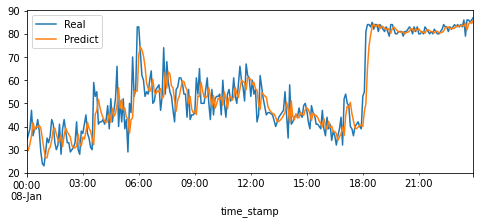

In [9]:
# compara a previsão com o conjunto de teste
results.plot(figsize=(8,3))

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [10]:
# validate predict with test set
def validate(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    print(f'mean_squared_error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'root_mean_squared_error: {rmse}')
    cd = r2_score(y_test, pred)
    print(f'Determination coeficient: {cd}')
    ev = explained_variance_score(y_test, pred)
    print(f'explained_variance_score: {ev}')
    me = max_error(y_test, pred)
    print(f'max_error: {me}')
    mae = mean_absolute_error(y_test, pred)
    print(f'mean_absolute_error: {mae}')
validate(test_set, predictions)

mean_squared_error: 47.47664435222476
root_mean_squared_error: 6.89032977093439
Determination coeficient: 0.8480198563543421
explained_variance_score: 0.8485318225689934
max_error: 31.141002098912487
mean_absolute_error: 4.873707137921264
